# Age idientification by the photo

## Введение
В данном проекте разрабатывется модель на основе ResNet50 для определения возраста человека по его фото.

Датасет загружен с [ChaLearn Looking at People](https://chalearnlap.cvc.uab.cat/). В итоге имеется папка с фото, а также csv файл со стобцами: 
 * Имя файла
 * возраст

Метрикой качества будет МАЕ. На тестовой выборке МАЕ должна быть не больше 6.5.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-whitegrid')
import seaborn as sns
import random

from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import  Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50

In [ ]:
from google.colab import drive
drive.mount('/content.gdrive')

Mounted at /content.gdrive


In [ ]:
labels = pd.read_csv('/content.gdrive/MyDrive/projects/11/labels.csv')
train_datagen = ImageDataGenerator(
                                    rescale=1./255,
                                   horizontal_flip=True,
                                     
                                   validation_split=0.25
                                   )
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/content.gdrive/MyDrive/projects/11/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345) 

Found 5694 validated image filenames.


In [ ]:
test_datagen = ImageDataGenerator(rescale= 1./255, validation_split=0.25)
test_gen_flow = test_datagen.flow_from_dataframe(
    dataframe=labels,
    directory='/content.gdrive/MyDrive/projects/11/final_files',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=16,
    class_mode='raw',
    subset='validation',
    seed=12345)

Found 1897 validated image filenames.


Всего 7591 фотографии, которые разбиты на пачки по 32 фотографии. В качестве аргументации - *horizontal_flip*. 

In [ ]:
features, target = next(train_gen_flow)
print('Размер тензора пачки:', features.shape)

Размер тензора пачки: (16, 224, 224, 3)


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


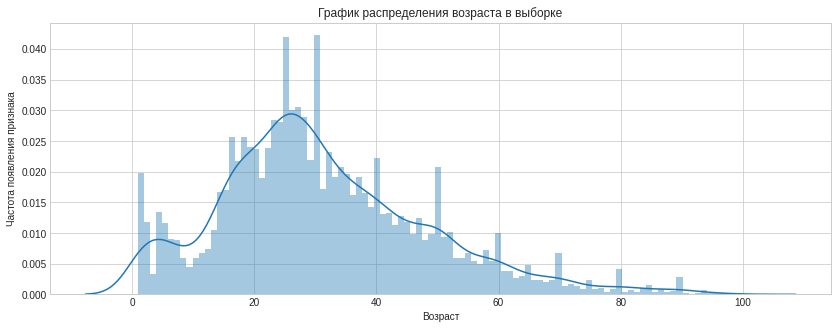

In [ ]:
plt.figure(figsize=(14,5))
sns.distplot(labels['real_age'], bins=100)
plt.title('График распределения возраста в выборке')
plt.xlabel('Возраст')
plt.ylabel('Частота появления признака')
plt.show()

По графику можно сделать выводы:
* В основном в выборке люди в возрасте от 20 до 30 лет. При этом есть и дети и очень пожилые люди.
* Довольно большой всплеск значений в возрасте до 5 лет. Имеются выбросы в круглые даты (25, 30, 50) можно объяснить тем, что данные о людях и их возрасте могли поступать из разных источников. Некоторые из них имели точный возраст, другие могли быть получены в результате анкетирования, где возраст указывался в интервале, например (25-29), (30 - 34). При обработке таких данных, они были приняты к круглой цифре в интервале.
* Данные по возрасту распределены неравномерно. Молодых людей значительно больше, чем детей или пожилых. Соответсвенно предсказания модели будут чаще в области от 18 до 40. Значит выборка недостаточна.
* люди из фотографий из выборки различаются не только по возрасту, но также
по цвету кожи,
 * фото анфас или профиль,
 * некоторые фото обрезают часть лица,
 * по выражению лица.



Выведу на экране несколько фотографий из пачки.

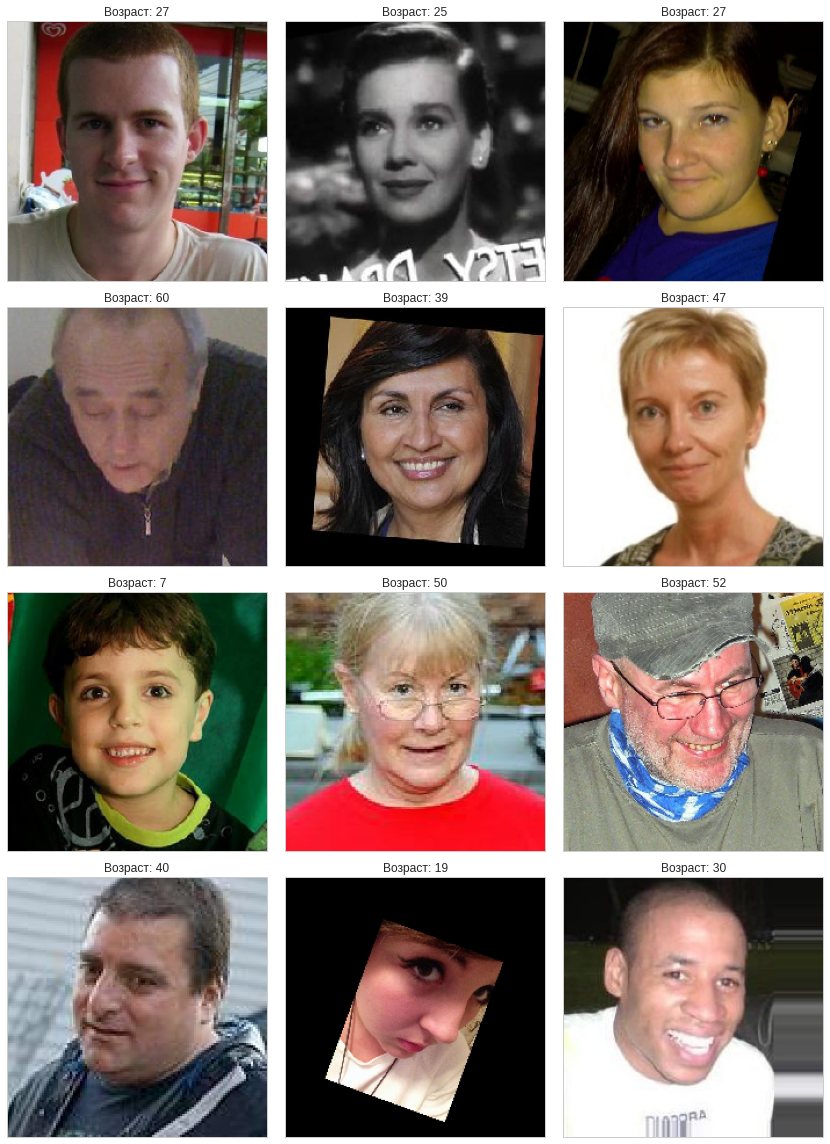

In [ ]:
sample = random.sample(range(16), 12)
fig = plt.figure(figsize=(12,16))
for i in range(12):
    fig.add_subplot(4, 3, i+1)
    plt.imshow(features[sample[i]])
    #удаление сетки
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.title(f'Возраст: {target[sample[i]]}')

### Вывод
Имеется большой датасет из фотографий (7591). Чтобы справится с таким объемом изображений, требуется подключить загрузчик данных.  Все изображения приведены к размеру $ 224 * 224 $  и разделены в пачки по 16 в каждой.

In [ ]:
backbone = ResNet50(input_shape=(224, 224, 3),
       weights='imagenet',
       include_top=False)

model = Sequential()
model.add(backbone)
    #Тут можно добавить один GlobalAveragePooling2D слой и один выходной слой
model.add(GlobalAveragePooling2D())

model.add(Dense(1, activation='relu')) 
optimizer = Adam(lr=0.0001)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

94781440/94765736 [==============================] - 1s 0us/step


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model.fit(train_gen_flow, 
              validation_data=test_gen_flow,
              epochs=15,
              batch_size=16,
              steps_per_epoch=len(train_gen_flow),
              validation_steps=len(test_gen_flow),
          verbose=2)

Epoch 1/15
356/356 - 1954s - loss: 222.8420 - mae: 10.6953 - val_loss: 555.0554 - val_mae: 18.5026 - 1954s/epoch - 5s/step
Epoch 2/15
356/356 - 156s - loss: 88.5756 - mae: 7.1379 - val_loss: 116.2286 - val_mae: 8.3297 - 156s/epoch - 437ms/step
Epoch 3/15
356/356 - 156s - loss: 64.0957 - mae: 6.1266 - val_loss: 105.4826 - val_mae: 7.8256 - 156s/epoch - 439ms/step
Epoch 4/15
356/356 - 156s - loss: 54.2212 - mae: 5.5839 - val_loss: 84.0150 - val_mae: 6.8909 - 156s/epoch - 439ms/step
Epoch 5/15
356/356 - 155s - loss: 37.2590 - mae: 4.6843 - val_loss: 98.9096 - val_mae: 7.5131 - 155s/epoch - 436ms/step
Epoch 6/15
356/356 - 155s - loss: 30.5699 - mae: 4.2275 - val_loss: 75.2701 - val_mae: 6.4928 - 155s/epoch - 436ms/step
Epoch 7/15
356/356 - 155s - loss: 23.8875 - mae: 3.7452 - val_loss: 72.2585 - val_mae: 6.3943 - 155s/epoch - 436ms/step
Epoch 8/15
356/356 - 155s - loss: 22.4909 - mae: 3.6105 - val_loss: 69.1066 - val_mae: 6.0971 - 155s/epoch - 436ms/step
Epoch 9/15
356/356 - 155s - loss: 1

MAE на обучающей выборке почти в 2 раза меньше, чем на отложенной, что означает, что модель переобучилась. Это может быть из за недостаточной обучающей выборки.